# Home Assignment No. 3: Part 1 (Theory and Practice)
To solve this task, you will write a lot of code to try several machine learning methods for dimensionality reduction and anomaly detection.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of your own code. There exists a class/method for almost everything you can imagine (related to this homework).

* To do this part of homework, you have to write **CODE** directly inside specified places inside notebook **CELLS**.

* In some problems you are asked to provide short discussion of the results. In these cases you have to create **MARKDOWN** cell with your comments right after the corresponding code cell.

* For every separate problem you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if the reviewer decides to execute all, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include neccessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.

## Task 1. Practice with Different Anomaly Detection Algorithms. (5 points)
### Task 1.1. (1 point)
Explore two One-Class SVM methods, write down corresponding minimization functions (try to keep equal notations) and explain the differences (1-2 sentences).
1. Scholkopf et al.: http://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf
2. Tax et al.:  https://link.springer.com/content/pdf/10.1023/B:MACH.0000008084.60811.49.pdf


1.
$\min \frac{1}{2}\|w\|^{2} + \frac{v}{l}\sum\limits_{i}\xi_{i} - \rho$,
subject to 

$w \Phi(x_i) \geq \rho - \xi_i, \xi_i > 0$

In first method we are separating the target objects from the origin maximizing the margin

2. $F(R, a) = R^2 + C \sum\limits_i \xi_i$,

$\forall i \ \|x_i - a\| \leq R^2 + \xi_i, \xi_i \geq 0 $

In second method we demand that the sphere contains all training objects and we want to maximize the margin between training set and outliers

In case of normilized data these two solutions are comparable

### Task 1.2. (2 points)

1. **(1 pt.)** For the `frod_detection` dataset,  predict the anomaly with any three sklearn built-in Anomaly detection methods: https://scikit-learn.org/stable/modules/outlier_detection.html

**Note:** do not forget to relabel predictions from Anomaly detection methods, as they could be negative.

2. **(1 pt.)** Estimate the __contamination__ (or impurity) on the training set as the ratio of anomaly objects in the whole sample. Explore, how the `roc_auc_score` changes with `contamination` value, taking a grid `[0.1*contamination, 1*contamination, 10*contamination]`. Point out the best performing algorithm.

In [5]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score

np.random.seed(42)

data = pd.read_csv('data/creditcard.csv')

X = data.drop(columns="Class")
y = data["Class"]

# keep the split fixed
tt_split = train_test_split(X, y, test_size = 0.1, stratify=y, random_state= 42)
train_X, test_X, train_y, test_y = tt_split 

# delete the targets for training
train_y = 0

In [2]:
# impurity estimation on test data
contamination = y.value_counts()[1] / len(y)

In [3]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

models = [OneClassSVM, IsolationForest, LocalOutlierFactor]

for estimator in models:
    print('-------')
    name = estimator().__class__.__name__
    print(f'Model: {name}')
    
    for i in [0.1, 1, 10]:

        # >>> your solution here <<<
        
        if name == 'IsolationForest':
            model = estimator(contamination=i * contamination)
        elif name == 'OneClassSVM':
            model = estimator(nu=i * contamination)
        elif name == 'LocalOutlierFactor':
            model = estimator(contamination=i * contamination, novelty=True)
        
        model.fit(train_X)
        labels_isolation = model.predict(test_X)
        labels_isolation[labels_isolation == 1] = 0
        labels_isolation[labels_isolation == -1] = 1

        print('Contamination: ', np.round(contamination * i, 3), ' ', 
              'ROC/AUC: ', np.round(roc_auc_score(test_y, labels_isolation), 3),
              'Precision: ', np.round(precision_score(test_y, labels_isolation, average = 'micro'), 3))

-------
Model: OneClassSVM
Contamination:  0.002   ROC/AUC:  0.499 Precision:  0.98
Contamination:  0.017   ROC/AUC:  0.488 Precision:  0.959
Contamination:  0.17   ROC/AUC:  0.51 Precision:  0.825
-------
Model: IsolationForest
Contamination:  0.002   ROC/AUC:  0.52 Precision:  0.984
Contamination:  0.017   ROC/AUC:  0.783 Precision:  0.987
Contamination:  0.17   ROC/AUC:  0.849 Precision:  0.841
-------
Model: LocalOutlierFactor
Contamination:  0.002   ROC/AUC:  0.499 Precision:  0.981
Contamination:  0.017   ROC/AUC:  0.499 Precision:  0.962
Contamination:  0.17   ROC/AUC:  0.505 Precision:  0.815


### Task 1.3. (2 points)

The idea is to see when anomaly detection methods, trained with no labels, can facilitate the prediction of the classifier. Imagine a real case scenario: you have labelled only a small portion of the dataset and a bunch of unlabeled data. We will simulate the situation when __90%__ of data is unlabeled and we still desire to achieve good performance.

As you can score your predictions only on the __10%__ of the sample, you better do it in cross validation to ensure the model stability.
1. **(1 pt.)** Take your favorite classifier and estimate the performance on __test set__ using `StratifiedKFold(n_splits=10, random_state = 42)` with `roc_auc` and `precision_score`. You can use test set upsampling and other instruments to enforce your prediction. 
2. **(1 pt.)**  Try to enhance the classifier performance in  `roc_auc` or `precision_score` (or ideally both), building the ensemble, using __Anomaly detection__ methods from the previous task. You can fit __Anomaly detection__ methods on both  __training set__ and subset from __test set__ on the cross-validation fold. Write 1-2 sentences on your findings.

__NOTE:__ try not to overfit, thus not adjust the `contamination` while training, and refit classifiers on each fold. 

__Hints:__ `sklearn.ensemble.VotingClassifier` does not support Anomaly detection methods, so you are to write it yourself. And `np.logical_and` or `np.logical_or` will suit for the trivial ensemble.

In [4]:
# your favorite classifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE

skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
skf.get_n_splits(test_X, test_y)

roc_auc_scores = []
pr_scores = []
model = GradientBoostingClassifier()

for train_index, test_index in skf.split(test_X, test_y):
    
    train_data, train_labels = SMOTE().fit_resample(test_X.iloc[train_index], test_y.iloc[train_index])
    model.fit(train_data, train_labels)
    
    preds = model.predict(test_X.iloc[test_index])
    
    roc_auc_scores.append(roc_auc_score(test_y.iloc[test_index], preds))
    pr_scores.append(precision_score(test_y.iloc[test_index], preds, average='micro'))
    
print('ROC/AUC mean: ', np.mean(roc_auc_scores), 'std: ', np.std(roc_auc_scores))    
print('Precision mean: ', np.mean(pr_scores), 'std: ', np.std(pr_scores))

ROC/AUC mean:  0.9578897949098097 std:  0.06614841571242738
Precision mean:  0.9944684405202244 std:  0.004148682478395065


In [10]:
# ensemble of classifiers
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
skf.get_n_splits(test_X, test_y)

roc_auc_scores = []
pr_scores = []

ifc = IsolationForest(contamination=contamination, random_state=42)
lof = LocalOutlierFactor(contamination=contamination, novelty=True)

ifc.fit(train_X)
lof.fit(train_X)

for train_index, test_index in skf.split(test_X, test_y):
    
    train_data, train_labels = SMOTE().fit_resample(test_X.iloc[train_index], test_y.iloc[train_index])
    model.fit(train_data, train_labels)
    
    anomaly_preds = np.logical_and(ifc.predict(test_X.iloc[test_index]), lof.predict(test_X.iloc[test_index]))
    
    anomaly_preds[anomaly_preds == 1] = 0
    anomaly_preds[anomaly_preds == -1] = 1
    
    preds = np.logical_or(model.predict(test_X.iloc[test_index]), anomaly_preds)
    
    roc_auc_scores.append(roc_auc_score(test_y.iloc[test_index], preds))
    pr_scores.append(precision_score(test_y.iloc[test_index], preds, average='micro'))
    
print('ROC/AUC mean: ', np.mean(roc_auc_scores), 'std: ', np.std(roc_auc_scores))    
print('Precision mean: ', np.mean(pr_scores), 'std: ', np.std(pr_scores))

ROC/AUC mean:  0.9477143563133185 std:  0.06724046592045806
Precision mean:  0.9937787853478104 std:  0.0045822277613786185


It is difficult to help complex method with simple anomaly ensemble. If tuned better (e.g. more different anomaly detection techniques and more complex conditions for combination), we might get a slight performance boost. Also, such ensembles can help weaker methods like LogReg.

## Task 2. Practice with Different Clustering Algorithms. (4 points)
### Task 2.1. Explore KMeans and Gaussian Mixture algorithms. (2 points)
Try **KMeans, Gaussian Mixture** and **two** more clustering algorithms from sklearn. 
To evaluate clustering performance use **two** clustering metrics: *silhouette score*
and *mutual information* or *adjusted mutual information*.

For each algorithm **your task** is to try to find the parameters leading to the best performance for `n_clusters=true_number_of_clusters`:
1. **(1 pt.)** Apply the algorithm with the true number of clusters and at least two **other settings** for the number of clusters: a smaller and a larger number than the true one;
2. **(1 pt.)** For each number of clusters **vizualize the clustering result**, calculate the **clustering metrics** and plot them;

__NOTE:__ `sklearn.model_selection.GridSearchCV` does not support clustering methods, thus you suppose to do it manually.

True number of clusters is 15


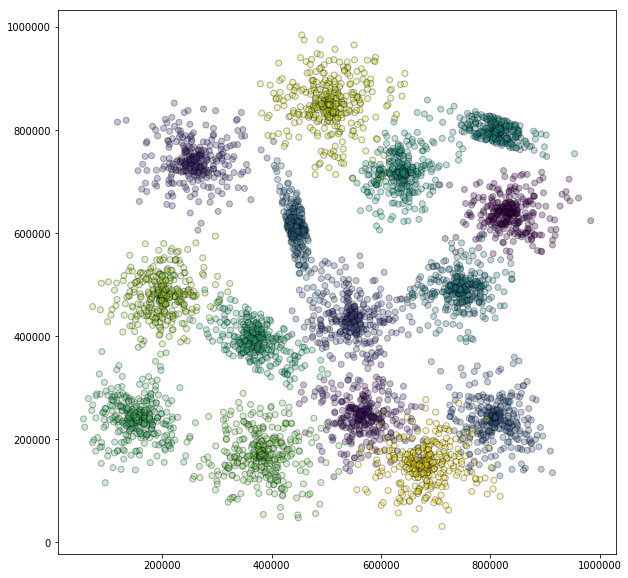

In [5]:
points, labels = np.loadtxt('data/clustering.txt'), np.loadtxt('data/clustering_labels.txt')
labels = labels.astype(int)
print("True number of clusters is {}".format(np.max(labels)))
plt.figure(figsize=(10, 10))
plt.scatter(points[:,0], points[:,1], c=labels, alpha=0.3, edgecolor='k')

plt.show()

In [46]:
def cluster_grid_search(X, y, estimator, params, metric):
    best_params = {}
    keys = params.keys()
    best_value = -1
    for combination in product(*(params[key] for key in keys)):
        param_set = dict(zip(keys, combination))
        try:
            model = estimator(**param_set)
            model.fit(X)
        except ValueError:
            continue

        try:
            preds = model.predict(X)
        except AttributeError:
            preds = model.labels_

        curr_value = metric(y, preds)

        if curr_value > best_value:
            best_params = param_set
            best_value = curr_value

    return best_value, best_params

estimator_grids = {
    'KMeans': {
        'n_clusters': [15],
        'n_init': [5, 10, 20],
        'init': ['k-means++', 'random'],
    },
    'GaussianMixture': {
        'n_components': [15],
        'covariance_type': ['full', 'tied', 'diag', 'spherical'],
        'init_params': ['kmeans', 'random'],
        'max_iter': [50, 100, 200, 400]
    },
    'Birch': {
        'n_clusters': [15],
        'branching_factor': [2, 15, 30, 50, 100],
        'threshold': [0.2, 0.5, 2, 5, 10]
    },
    'AgglomerativeClustering': {
        'n_clusters': [15],
        'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
        'linkage': ["ward", "single", "average", "complete"]
    }
}

In [50]:
### BEGIN Solution
from sklearn.cluster import KMeans, Birch, AffinityPropagation, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, mutual_info_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from itertools import product

models = [KMeans, GaussianMixture, Birch, AgglomerativeClustering]
models_best_params = []

params = {'n_clusters' : np.arange(10, 20, 1)}

metrics = dict()

print('silhouette score for true labels:', silhouette_score(points, labels))

for estimator in models:
    print('-------')
    name = estimator().__class__.__name__
    print(f'Model: {name}')
    best_mi, best_params = cluster_grid_search(
        points,
        labels,
        estimator,
        estimator_grids[name],
        mutual_info_score
    )
    print(f'best mi score: {best_mi}')
    
    model = estimator(**best_params)
    model.fit(points)
    try:
        preds = model.predict(points)
    except AttributeError:
        preds = model.labels_

    print(f'best silhoette score: {silhouette_score(points, preds)}') 
    print(f'best params: {best_params}')
    models_best_params.append(best_params)
          
    silhouettes = []
    mis = []
    for num in params['n_clusters']:
        if name == 'GaussianMixture':
            best_params['n_components'] = int(num)
        else:
            best_params['n_clusters'] = int(num)
        
        model = estimator(**best_params)
        model.fit(points)
        try:
            preds = model.predict(points)
        except AttributeError:
            preds = model.labels_
            
        silhouettes.append(silhouette_score(points, preds))
        mis.append(mutual_info_score(labels, preds))
    
    metrics[name] = (silhouettes, mis)

silhouette score for true labels: 0.6088944608894215
-------
Model: KMeans
best mi score: 2.5614788236303343
best silhoette score: 0.626169141840935
best params: {'n_clusters': 15, 'n_init': 20, 'init': 'random'}
-------
Model: GaussianMixture
best mi score: 2.567500298256902
best silhoette score: 0.5832591685823639
best params: {'n_components': 15, 'covariance_type': 'full', 'init_params': 'kmeans', 'max_iter': 50}
-------
Model: Birch
best mi score: 2.5077832875665407
best silhoette score: 0.6075939207380119
best params: {'n_clusters': 15, 'branching_factor': 2, 'threshold': 0.2}
-------
Model: AgglomerativeClustering
best mi score: 2.519454846864759
best silhoette score: 0.6091772373449134
best params: {'n_clusters': 15, 'affinity': 'euclidean', 'linkage': 'average'}


/home/sanityseeker/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


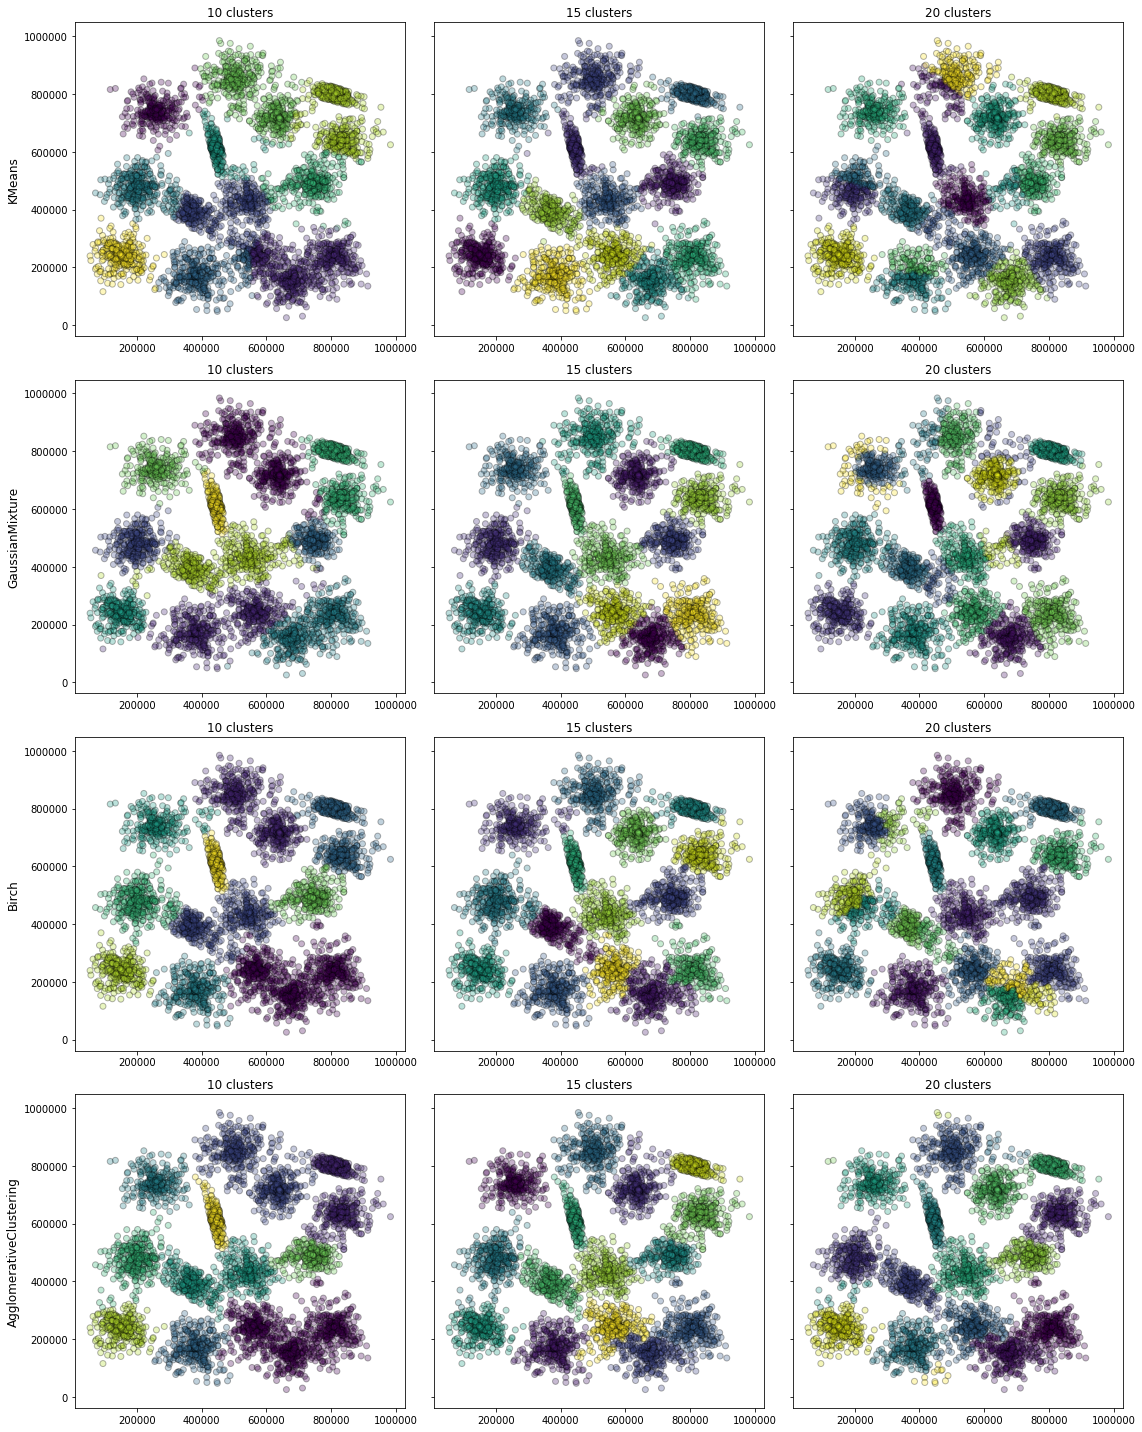

In [52]:
clusters_nums = [10, 15, 20]

fig, ax = plt.subplots(len(models), len(clusters_nums), figsize=(16, 20), sharey=True)

for i, (estimator, best_params) in enumerate(zip(models, models_best_params)):
    name = estimator().__class__.__name__
    
    ax[i][0].set_ylabel(name, rotation=90, size='large')
    
    for j, num in enumerate(clusters_nums):
        ax[i][j].set_title(f'{num} clusters')
        
        if name == 'GaussianMixture':
            best_params['n_components'] = int(num)
        else:
            best_params['n_clusters'] = int(num)
        
        model = estimator(**best_params)
        
        model.fit(points)
        try:
            preds = model.predict(points)
        except AttributeError:
            preds = model.labels_
        
        ax[i][j].scatter(points[:, 0], points[:, 1], c=preds, alpha=0.3, edgecolor='k')

fig.tight_layout()
fig.show()

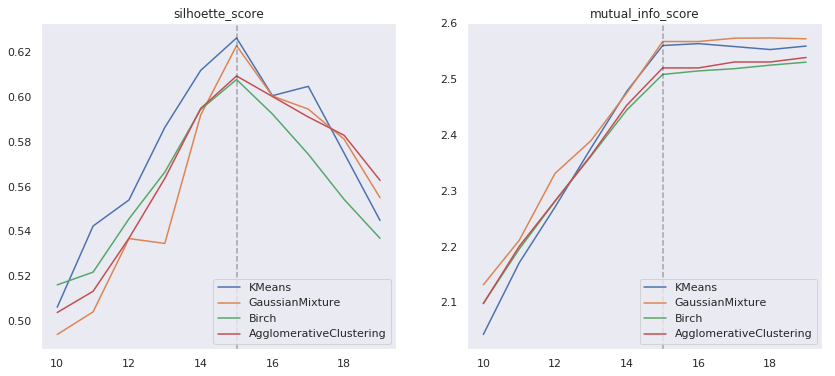

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

for i, title in enumerate(['silhoette_score', 'mutual_info_score']):
    ax[i].set_title(title)

    for name in metrics.keys():
        ax[i].plot(params['n_clusters'], metrics[name][i], label=name)
    ax[i].grid()
    ax[i].axvline(x=15, linestyle='--', color='black', alpha=0.3)
    ax[i].legend()
    
fig.show()

### Task 2.2. Finding the Number of Clusters with Bootstrap. (2 points)
For a chosen algorithm find the best number of clusters using bootstrap. Based on your observations made at previous task, choose one algorithm assuming **you do not have true labels and do not know the true number of clusters**.
1. **(1 pt.)** Estimate variance of the metric and construct normal 95% **confidence interval (CI)**;
2. **(1 pt.)** **Plot the metric** with the corresponding confidence intervals and show the best number of clusters.

__Hints:__  
- you can choose bootstrap samples with any size, and sample number starting from `50`;
- you can use `scipy.stats.norm.interval()` to derive CI;

In [57]:
from scipy.stats import norm
from sklearn.utils import resample

from tqdm import tqdm_notebook, tqdm

cluster_ns = np.arange(10, 20, 1)
sample_number = 150
iterations = 200

estimator = KMeans
silhouette_scores = []


for i, n_clusters in enumerate(tqdm_notebook(cluster_ns)):
    scores = []
    for j in range(iterations):
        index = np.random.randint(0, points.shape[0], sample_number)
        X = points[index]
        model = estimator(n_clusters=n_clusters)
        model.fit(X)
        preds = model.predict(X)
        scores.append(silhouette_score(X, preds))
    var = np.var(scores)
    mean = np.mean(scores)
    confidence = norm.interval(0.95, mean, var)
    silhouette_scores.append((mean, confidence))
    print(n_clusters)
    print(var, confidence)

10
0.0005396841500811441 (0.5350521137100708, 0.5371676367044431)
11
0.0005356086573076366 (0.561238530944471, 0.5633380783007327)
12
0.0005349142618942453 (0.5790270269967462, 0.5811238523730052)
13
0.0005803175285114323 (0.5984780354219021, 0.6007528383328615)
14
0.0005087116475023316 (0.616638017287881, 0.6186321303031223)
15
0.0006503572522818163 (0.6249663668448665, 0.6275157204279801)
16
0.0005823218582739424 (0.6140815277832051, 0.6163641875224598)
17
0.0006049531789957568 (0.6029874645324519, 0.6053588374187814)
18
0.0006541230534728141 (0.5909488464532496, 0.5935129617057778)
19
0.0006032343015079287 (0.5821123303383687, 0.5844769653487581)



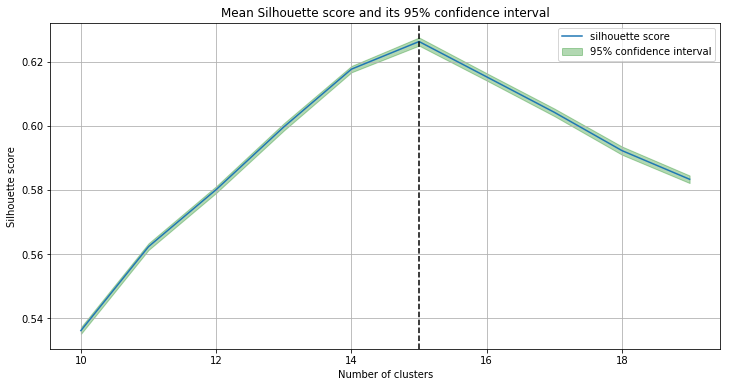

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.set_ylabel('Silhouette score')
ax.set_xlabel('Number of clusters')
ax.plot(cluster_ns, [mean for mean, (low, high) in silhouette_scores], label='silhouette score')
ax.fill_between(cluster_ns, 
                 [low for mean, (low, high) in silhouette_scores],
                 [high for mean, (low, high) in silhouette_scores],
                 alpha=0.3,
                 label='95% confidence interval',
                 color='g')
ax.set_title('Mean Silhouette score and its 95% confidence interval')
ax.axvline(x=15, linestyle='--', color='black')
ax.legend()
ax.grid()

## Task 3. MNIST, kMNIST component analysis and manifold learning. (6 points)
### Task 3.1. (2 points)

Download `MNIST` dataset. Here we will estimate the data intrinsic dimentionality, decompose the dataset on pinciple components and estimate the cumulative explained variance by each component.

You can either use the [proposed method](https://www.stat.berkeley.edu/~bickel/mldim.pdf) for the estimation of sample intrinsic dimension or any other method (convenient for you). For the first case use can use the code from [here](https://gist.github.com/mehdidc/8a0bb21a31c43b0cbbdd31d75929b5e4)

1. **(1 pt.)** Estimate the intrinsic dimentionality of the dataset. Provide the plot.
2. **(1 pt.)** Decompose the data on principal components (PCA). Plot the cumulative explained variance by each component. Plot the example of back-decomposition with **6** different set of components and corresponding explained variance. You can choose any digit from the dataset.

In [6]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import seaborn as sns

sns.set()

dg = datasets.load_digits()

data = StandardScaler().fit_transform(dg.data)

In [7]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors


def intrinsic_dim_sample_wise(X, k=5):
    neighb = NearestNeighbors(n_neighbors=k+1).fit(X)
    # distances between the samples and points
    dist, ind = neighb.kneighbors(X)
    # the distance between the first points to first points (as basis ) equals zero
    dist = dist[:, 1:]
    # the first non trivial point
    dist = dist[:, 0:k]  # including points k-1
    # requirments are there is no equal points
    assert dist.shape == (X.shape[0], k)
    assert np.all(dist > 0)
    # dinstance between the bayeasan estatistics
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k-1])
    d = d.sum(axis=1) / (k - 2)
    d = 1. / d
    intdim_sample = d
    return intdim_sample


def intrinsic_dim_scale_interval(X, k1=10, k2=20):
    # remove duplicates in case you use bootstrapping
    X = pd.DataFrame(X).drop_duplicates().values
    intdim_k = []
    for k in range(k1, k2 + 1):  # in order to reduce the noise by eliminating of the nearest neibours
        m = intrinsic_dim_sample_wise(X, k).mean()
        intdim_k.append(m)
    return intdim_k


def repeated(func, X, nb_iter=100, random_state=None, mode='bootstrap', **func_kw):
    if random_state is None:
        rng = np.random
    else:
        rng = np.random.RandomState(random_state)
    nb_examples = X.shape[0]
    results = []

    iters = range(nb_iter)
    for i in iters:
        if mode == 'bootstrap':  # and each point we want to resample with repeating points to reduce the errors
            # 232 111 133
            Xr = X[rng.randint(0, nb_examples, size=nb_examples)]
        elif mode == 'shuffle':
            ind = np.arange(nb_examples)
            rng.shuffle(ind)
            Xr = X[ind]
        elif mode == 'same':
            Xr = X
        else:
            raise ValueError('unknown mode : {}'.format(mode))
        results.append(func(Xr, **func_kw))
    return results

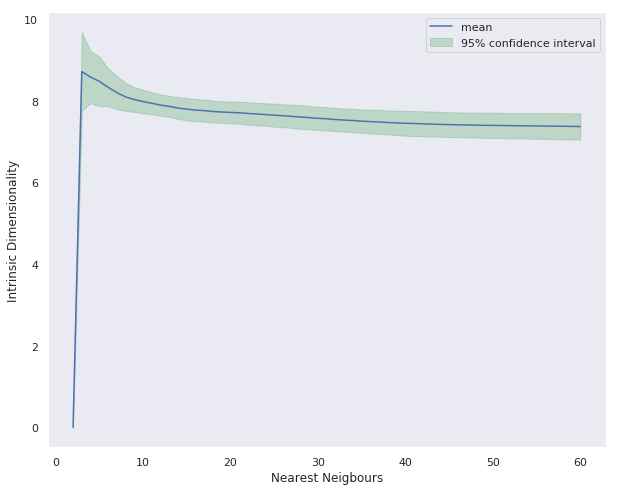

In [63]:
# based on clustering seminar

import warnings
warnings.filterwarnings("ignore")  # okay..

nb_iter = 25
start = 2
end = 60
nn = np.arange(start, end + 1, 1)


intdim_k_repeated = np.array(
    repeated(intrinsic_dim_scale_interval,
             data,
             mode='bootstrap',
             nb_iter=nb_iter,
             k1=start,
             k2=end)
)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

mean = np.mean(intdim_k_repeated, axis=0)
std = np.std(intdim_k_repeated, axis=0)

ax.plot(nn, mean, label='mean')
ax.fill_between(nn,
                mean - 2 * std,
                mean + 2 * std,
                alpha=0.3,
                label='95% confidence interval',
                color='g')

ax.set_xlabel("Nearest Neigbours")
ax.set_ylabel("Intrinsic Dimensionality")

ax.legend()
ax.grid()

fig.show()

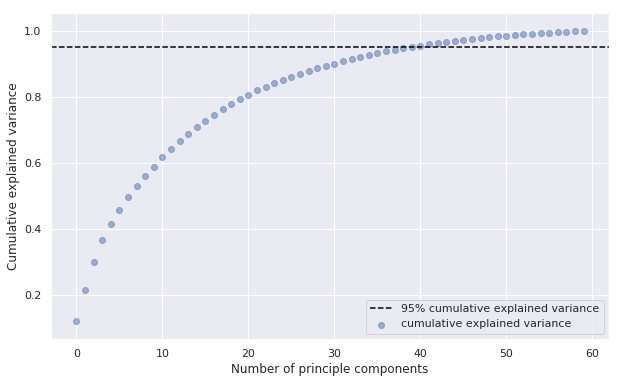

In [64]:
from sklearn.decomposition import PCA

num_components = 60
pca = PCA(n_components=num_components)
pca.fit(data)
pca_data = pca.transform(data)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(np.arange(num_components),
           pca.explained_variance_ratio_.cumsum(),
           alpha=0.5,
           label='cumulative explained variance')

ax.axhline(y=0.95,
           linestyle='--',
           color='black',
           label='95% cumulative explained variance')
ax.legend()

ax.set_xlabel('Number of principle components')
ax.set_ylabel('Cumulative explained variance')

fig.show()

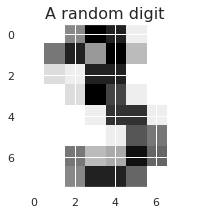

In [140]:
# Plot the example of back-decomposition with 6 different
# set of components and corresponding explained variance. You can choose any digit from the dataset.
digit = 3

plt.figure(5, figsize=(3, 3))
plt.imshow(dg.images[digit], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('A random digit', fontsize=16)
plt.show()

y = dg.target
X = dg.images.reshape(-1, 8 * 8) / dg.images.max()

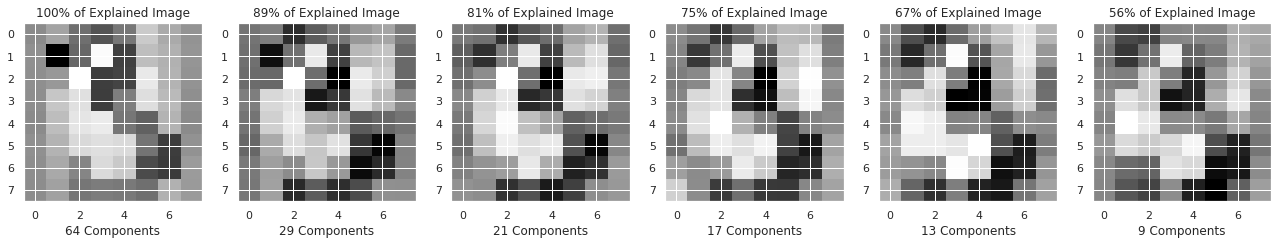

In [117]:
pca_dimentions = [64, 29, 21, 17, 13, 9]

fig, ax = plt.subplots(1, len(pca_dimentions), figsize=(18, 9))

for i, dim in enumerate(pca_dimentions):
    pca = PCA(n_components=dim)
    pca.fit(data)
    pca_data = pca.transform(data)
    restored_data = pca.inverse_transform(pca_data)
    ax[i].set_title(f'{pca.explained_variance_ratio_.cumsum()[-1] * 100:.0f}% of Explained Image')
    ax[i].imshow(restored_data[digit].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    ax[i].set_xlabel(f'{dim} Components')

fig.tight_layout()
fig.show()

### Task 3.2. (2 points)

Here we will visualise the decomposition in order to observe how data diverges across different manofild learning methods. We are  to compare `PCA`, `ICA` and `Isomap` non-linear decompositions (see more over here https://scikit-learn.org/stable/modules/manifold.html ), and check the classification accuracy on the new features. 

1. Visualise ICA, PCA and Isomap 3D decomposition on 3 components in `plotly`. Make sure the data is whitened (scaled), enjoy nice plots :) 
2. **(1 pt.)** Calculate new features on the data with ICA, PCA and Isomap. **Choose the number of components according to your estimation of intrinsic dimention**. Calculate the classification accuracy on these features with `LogisticRegression` on `cross_val=5` with $3$ repeats. Use `RepeatedKFold` and fit the `random_seed = 42`.
3. **(1 pt.)** Show that the `Isomap` gives statistically significant improvement on the classification accuracy with any appropriate statistical test. Provide corresponding `p-values`. Justify your results, write down 2-3 senteces.

__NOTE:__ In first task, `plotly` will not display the plot in offline notebook, so it is just for you to visualize the projection in 3D.

In [8]:
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import colorlover as cl

init_notebook_mode(connected=True)

In [119]:
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import Isomap

pca = PCA(n_components=3)
S_pca_ = pca.fit_transform(StandardScaler().fit_transform(X))

ica = FastICA(n_components=3)
S_ica_ = ica.fit_transform(StandardScaler().fit_transform(X))

iso = Isomap(n_components=3)
S_iso_ = ica.fit_transform(StandardScaler().fit_transform(X))

In [120]:
def plot_3d(X, y, title=''):
    
    digits_3d = pd.DataFrame({
        'x': X[:, 0], 
        'y': X[:, 1], 
        'z': X[:, 2],
        'label': y,
    })

    colors = cl.scales['10']['qual']['Paired']
    data = []

    for i in range(10):
        x = digits_3d[digits_3d['label'].astype('int') == i]['x']
        y = digits_3d[digits_3d['label'].astype('int') == i]['y']
        z = digits_3d[digits_3d['label'].astype('int') == i]['z']

        color = colors[i]

        trace = {
            'name': str(i),
            'x': x,
            'y': y,
            'z': z,
            'type': 'scatter3d',
            'mode': 'markers',
            'marker': {
                'size': 5,
                'color': color 
            }
        }
        data.append(trace)

    layout = go.Layout(
        title= title,
        width=900,
        height=600
    )

    fig = go.Figure(data=data, layout=layout)

    iplot(fig, show_link = False)

In [91]:
plot_3d(S_pca_, y, 'PCA')

In [92]:
plot_3d(S_ica_, y, 'ICA')

In [93]:
plot_3d(S_iso_, y, 'IsoMap')

Calculate new features on the data with ICA, PCA and Isomap and the classification accuracy on these features


In [224]:
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial')
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
rkf.get_n_splits()

methods = [PCA, FastICA, Isomap]
n_components = 8

result_table = pd.DataFrame()
results = {}

for dim_red in methods:
    name = dim_red.__name__
    model = dim_red(n_components=n_components)
    
    acc = []
        
    for train_index, test_index in rkf.split(X, y):        
        train_data, train_labels = X[train_index], y[train_index]
        test_data, test_labels = X[test_index], y[test_index]
        
        train_data = model.fit_transform(train_data)
        test_data = model.transform(test_data)
        
        logreg.fit(train_data, train_labels)
        
        preds = logreg.predict(test_data)
        acc.append(accuracy_score(test_labels, preds))
    
    result_table = result_table.append({
        'method': name,
        'mean_accuracy': np.mean(acc),
        'std_accuracy': np.std(acc)}, 
        ignore_index=True)
    
    results[name] = acc
    
result_table.set_index('method', inplace=True)

In [227]:
result_table

,mean_accuracy,std_accuracy
method,,
PCA,0.899446,0.014793
FastICA,0.796613,0.034200
Isomap,0.973678,0.008220


In [228]:
from scipy.stats import ttest_ind

In [229]:
pca_ica_pval = ttest_ind(results['PCA'], results['FastICA']).pvalue

print(f'Statistically significant improvement of PCA decomposition over ICA: p-value {pca_ica_pval}')

Statistically significant improvement of PCA decomposition over ICA: p-value 3.4559121243251255e-35


In [230]:
isomap_ica_pval = ttest_ind(results['FastICA'], results['Isomap']).pvalue

print(f'Statistically significant improvement of Isomap decomposition over ICA: p-value {isomap_ica_pval}')

Statistically significant improvement of Isomap decomposition over ICA: p-value 1.8535678418583592e-57


In [231]:
isomap_pca_pval = ttest_ind(results['PCA'], results['Isomap']).pvalue

print(f'Statistically significant improvement of Isomap decomposition over PCA: p-value {isomap_pca_pval}')

Statistically significant improvement of Isomap decomposition over PCA: p-value 4.4198494138694104e-52


The low p-value between Isomap accuracy scores and PCA/ICA accuracy scores indicates that the distribution of such scores are very unlikely to be the same. Thus, we can say that Isomap provide statistically significant improvement over PCA and ICA methods. 

### Task 3.3. kMNIST dimensionality reduction. (2 points)

Explore `KMNIST` dataset https://github.com/rois-codh/kmnist. You are to engeneer new features (by using any familiar to you method of Manifold Learning) to increase the classification accuracy. Use the `KNN` classifier with any hyperparameters you like.

1. __(2 pt.)__ Get accuracy on `test_set` more than `93%`. Is it fair to `fit` with manifold Learning method for both train and test samples? 

**NOTE** that the data is rather heavy, thus your decomposition will take a while.

__Hint:__ Try to use dimensionality reduction methods, which yield better model performance on `MNIST`. These methods can compete with Autoencoders on `torch`, you will find it in __Part 2__.  Save 3 first components of your projection on `train` sample to `.csv`, we are going to visually compare them later.


In [9]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.decomposition import PCA

def load(f):
    return np.load(f)['arr_0']

# Load the data
x_train = load('data/kmnist/kmnist-train-imgs.npz')
x_test = load('data/kmnist/kmnist-test-imgs.npz')
y_train = load('data/kmnist/kmnist-train-labels.npz')
y_test = load('data/kmnist/kmnist-test-labels.npz')

# Reshape the data
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

/home/sanityseeker/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



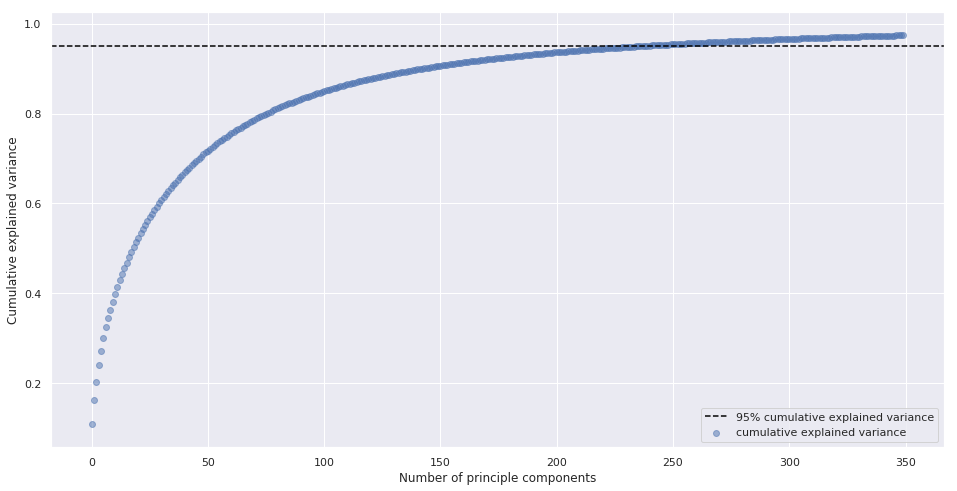

In [10]:
num_components = 350
pca = PCA(n_components=num_components)
pca.fit(x_train, y_train)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.scatter(np.arange(num_components),
           pca.explained_variance_ratio_.cumsum(),
           alpha=0.5,
           label='cumulative explained variance')

ax.axhline(y=0.95,
           linestyle='--',
           color='black',
           label='95% cumulative explained variance')
ax.legend()

ax.set_xlabel('Number of principle components')
ax.set_ylabel('Cumulative explained variance')

fig.show()

In [11]:
pca_data = pca.transform(x_train)
np.savetxt("mnist_three.csv", pca_data[:, :3], delimiter=",")

In [194]:
cls = KNeighborsClassifier(n_jobs=-1)

In [205]:
train_data = pca.fit_transform(x_train)
test_data = pca.transform(x_test)

accuracies = []
for num in tqdm_notebook(range(10, num_components, 10)):
    cls.fit(train_data[:, :num], y_train)
    preds = cls.predict(test_data[:, :num])
    accuracies.append(accuracy_score(y_test, preds))

KeyboardInterrupt: 

Well, this should be enough to evaluate the results...

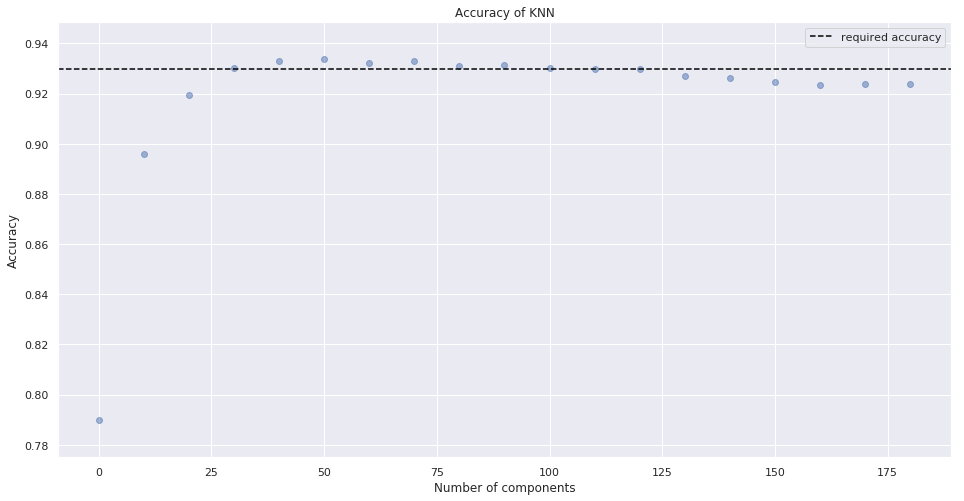

In [210]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.scatter(np.arange(len(accuracies)) * 10, accuracies, alpha=0.5)

ax.axhline(y=0.93,
           linestyle='--',
           color='black',
           label='required accuracy')
ax.legend()

ax.set_title('Accuracy of KNN')
ax.set_xlabel('Number of components')
ax.set_ylabel('Accuracy')

fig.show()

**Voilla! you are done, have a good day ;)**